In [35]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import gc
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import pandas as pd
import shutil
from collections import defaultdict

# Set GPU memory growth to avoid allocating all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU devices and enabled memory growth")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")


SEED = 3888
def set_seed(seed=3888):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(SEED)

# Define image size and batch size
IMG_SIZE = 224  # Standard input size for ResNet50
BATCH_SIZE = 32

Found 1 GPU devices and enabled memory growth


In [14]:
type_to_label_map = {
    'Non-Tumor': 0,
    'Tumor': 1,
    'Empty': 2
}

In [3]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0
    
    return img_array

In [15]:
def load_data(dir, target_size=(224, 224)):
    X_data = []
    y_data = []
    

    for quadrant in os.listdir(dir):
        quadrant_path = os.path.join(dir, quadrant)
        X_data_quadrant = []
        y_data_quadrant = []
        
        for cell_type in os.listdir(quadrant_path):
            cell_type_path = os.path.join(quadrant_path, cell_type)
            # print(f"Processing quadrant: {quadrant}, cell type: {cell_type}")
            
            if os.path.isdir(cell_type_path):
                for filename in os.listdir(cell_type_path):
                    if filename.endswith(".png") or filename.endswith(".jpg"):
                        img_path = os.path.join(cell_type_path, filename)
                        img = preprocess_image(img_path, target_size=target_size)
                        # print(img.shape)
                        # print(is_cancer_cell[cell_type])
                        # print(f"Processing image: {img_path}\n")
                        
                        X_data_quadrant.append(img)
                        y_data_quadrant.append(type_to_label_map[cell_type])  
                        
        X_data.append(np.array(X_data_quadrant))
        y_data.append(np.array(y_data_quadrant))

    
    return (X_data, y_data)


In [ ]:
# Calculate and plot the distribution of samples in each quadrant by category
def plot_data_distribution(data_dir):
    quadrant_names = ["Q1", "Q2", "Q3", "Q4"]
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Define category label mapping
    categories = ['Non-Tumor', 'Tumor', 'Empty']
    colors = ['skyblue', 'tomato', 'lightgreen']
    
    for i, quadrant in enumerate(quadrant_names):
        # Initialize counters
        counts = {cat: 0 for cat in categories}
        
        quadrant_path = os.path.join(data_dir, quadrant)
        if os.path.exists(quadrant_path):
            # Iterate through each category in the quadrant directory
            for cell_type in os.listdir(quadrant_path):
                cell_type_path = os.path.join(quadrant_path, cell_type)
                if os.path.isdir(cell_type_path):
                    # Count the number of images in each category
                    n_images = len([f for f in os.listdir(cell_type_path) 
                                  if f.endswith('.png') or f.endswith('.jpg')])
                    counts[cell_type] += n_images
        
        # Draw bar chart
        x = range(len(categories))
        count_values = [counts[cat] for cat in categories]
        
        axes[i].bar(x, count_values, color=colors)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(categories)
        axes[i].set_title(f'{quadrant} Data Distribution')
        axes[i].set_ylabel('Number of Samples')
        
        # Display values above the bars
        for j, v in enumerate(count_values):
            axes[i].text(j, v + 5, str(v), ha='center')
    
    plt.tight_layout()
    plt.suptitle('Sample Distribution by Category in Each Quadrant', fontsize=16, y=1.05)
    plt.show()

# Call function to plot data distribution
plot_data_distribution("projectdata/images/100_stratified4fold_1000per_seed3888")

In [31]:
def create_resnet_model(learning_rate=0.0001, input_shape=(224, 224, 3), seed=3888):
    K.clear_session()
    set_seed(seed)

    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # 前期冻结，后期可以微调

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    # 更深的分类头
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [70]:
def quandrant_cv(X_datas, y_datas, model_func, epochs=10, batch_size=16, learning_rate=0.001):
    # Ensure input data is correct
    assert len(X_datas) == 4, "Need to provide X data for 4 quadrants"
    assert len(y_datas) == 4, "Need to provide y data for 4 quadrants"
    
    # Define quadrant names
    quadrant_names = ["Q1", "Q2", "Q3", "Q4"]
    
    # Save results
    results = {
        'accuracies': [],
        'f1_scores': [],
        'auc_scores': [],
        'confusion_matrices': [],
        'histories': [],
        'test_quadrants': [],
        'y_true': [],
        'y_pred': [],
        'y_prob': []
    }
    
    # Perform leave-one-out cross validation for each quadrant
    for test_idx in range(4):
        print(f"\n=== Fold {test_idx+1} Cross Validation - Test Quadrant: {quadrant_names[test_idx]} ===")
        
        # Select test set
        X_test = X_datas[test_idx]
        y_test = y_datas[test_idx]
        
        # Merge other three quadrants as training set
        train_indices = [i for i in range(4) if i != test_idx]
        X_train = np.concatenate([X_datas[i] for i in train_indices])
        y_train = np.concatenate([y_datas[i] for i in train_indices])
        
        # Convert to categorical labels
        y_train_cat = to_categorical(y_train, num_classes=3)
        y_test_cat = to_categorical(y_test, num_classes=3)
        
        print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
        print(f"Training set label distribution: {np.unique(y_train, return_counts=True)}")
        print(f"Test set label distribution: {np.unique(y_test, return_counts=True)}")
        
        # Create and train model
        model = model_func(
            learning_rate=learning_rate,
            seed=SEED
        )
        
        # Add early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            X_train, y_train_cat,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
        
        # Predict
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1)
        y_true = y_test
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate AUC
        try:
            fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
            auc_score = auc(fpr, tpr)
        except:
            auc_score = 0
            
        # Save results
        results['accuracies'].append(accuracy)
        results['f1_scores'].append(f1)
        results['auc_scores'].append(auc_score)
        results['confusion_matrices'].append(cm)
        results['histories'].append(history)
        results['test_quadrants'].append(quadrant_names[test_idx])
        results['y_true'].append(y_true)
        results['y_pred'].append(y_pred)
        results['y_prob'].append(y_prob)
        
        # Output evaluation metrics for current fold
        print(f"\nCurrent fold ({quadrant_names[test_idx]} as test set):")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print("Confusion Matrix:")
        print(cm)
        
        # Free memory
        K.clear_session()
        gc.collect()
        tf.compat.v1.reset_default_graph()
        
    # Calculate average metrics
    avg_accuracy = np.mean(results['accuracies'])
    avg_f1 = np.mean(results['f1_scores'])
    avg_auc = np.mean(results['auc_scores'])
    
    print("\n=== Cross Validation Summary ===")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f"Average AUC: {avg_auc:.4f}")
    
    return results

In [ ]:
def plot_cv_metrics(results):
    """Plot evaluation metrics for each CV fold"""
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    
    # Accuracy
    ax[0].bar(results['test_quadrants'], results['accuracies'], color='skyblue')
    ax[0].axhline(y=np.mean(results['accuracies']), color='red', linestyle='--', label=f'Mean: {np.mean(results["accuracies"]):.4f}')
    ax[0].set_ylim([0, 1])
    ax[0].set_title('Test Accuracy per Fold')
    ax[0].set_xlabel('Test Quadrant')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    # F1 Score
    ax[1].bar(results['test_quadrants'], results['f1_scores'], color='lightgreen')
    ax[1].axhline(y=np.mean(results['f1_scores']), color='red', linestyle='--', label=f'Mean: {np.mean(results["f1_scores"]):.4f}')
    ax[1].set_ylim([0, 1])
    ax[1].set_title('Test F1 Score per Fold')
    ax[1].set_xlabel('Test Quadrant')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, class_names=None):
    """Plot confusion matrices for each fold"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    if class_names is None:
        # Default to three-class labels
        class_names = ['Non-Tumor', 'Tumor', 'Empty']

    for i, (cm, quadrant) in enumerate(zip(results['confusion_matrices'], results['test_quadrants'])):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=class_names, yticklabels=class_names)
        axes[i].set_title(f'Test Quadrant: {quadrant}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

def plot_learning_curves(results):
    """Plot learning and loss curves for each fold"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (history, quadrant) in enumerate(zip(results['histories'], results['test_quadrants'])):
        axes[i].plot(history.history['accuracy'], label='Training Accuracy')
        axes[i].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[i].set_title(f'Learning Curve - Quadrant {quadrant}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (history, quadrant) in enumerate(zip(results['histories'], results['test_quadrants'])):
        axes[i].plot(history.history['loss'], label='Training Loss')
        axes[i].plot(history.history['val_loss'], label='Validation Loss')
        axes[i].set_title(f'Loss Curve - Quadrant {quadrant}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

In [77]:
# Run four-quadrant cross validation
# Get previously loaded data
X_datas, y_datas = load_data("projectdata/images/100_stratified4fold_1000per_seed3888")

# Set training parameters
params = {
    'epochs': 10,          # Number of training epochs
    'batch_size': 4,      # Batch size
    'learning_rate': 0.001, # Learning rate
}

# Run cross validation
cv_results = quandrant_cv(
    X_datas=X_datas,
    y_datas=y_datas,
    model_func=create_resnet_model,
    **params
)


=== Fold 1 Cross Validation - Test Quadrant: Q1 ===
Training set shape: (3196, 224, 224, 3), Test set shape: (1050, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1387,  300], dtype=int64))
Test set label distribution: (array([0, 1, 2]), array([503, 447, 100], dtype=int64))
Epoch 1/10
639/639 [==============================] - 14s 19ms/step - loss: 0.9992 - accuracy: 0.5575 - val_loss: 1.8662 - val_accuracy: 0.2578
Epoch 2/10
639/639 [==============================] - 11s 17ms/step - loss: 0.8255 - accuracy: 0.5966 - val_loss: 0.4904 - val_accuracy: 0.8016
Epoch 3/10
639/639 [==============================] - 11s 17ms/step - loss: 0.7540 - accuracy: 0.6264 - val_loss: 1.2573 - val_accuracy: 0.7812
Epoch 4/10
639/639 [==============================] - 10s 16ms/step - loss: 0.7036 - accuracy: 0.6514 - val_loss: 1.1608 - val_accuracy: 0.2188
Epoch 5/10
639/639 [==============================] - 10s 16ms/step - loss: 0.6620 - accuracy: 0.6682 - val_loss: 0.5

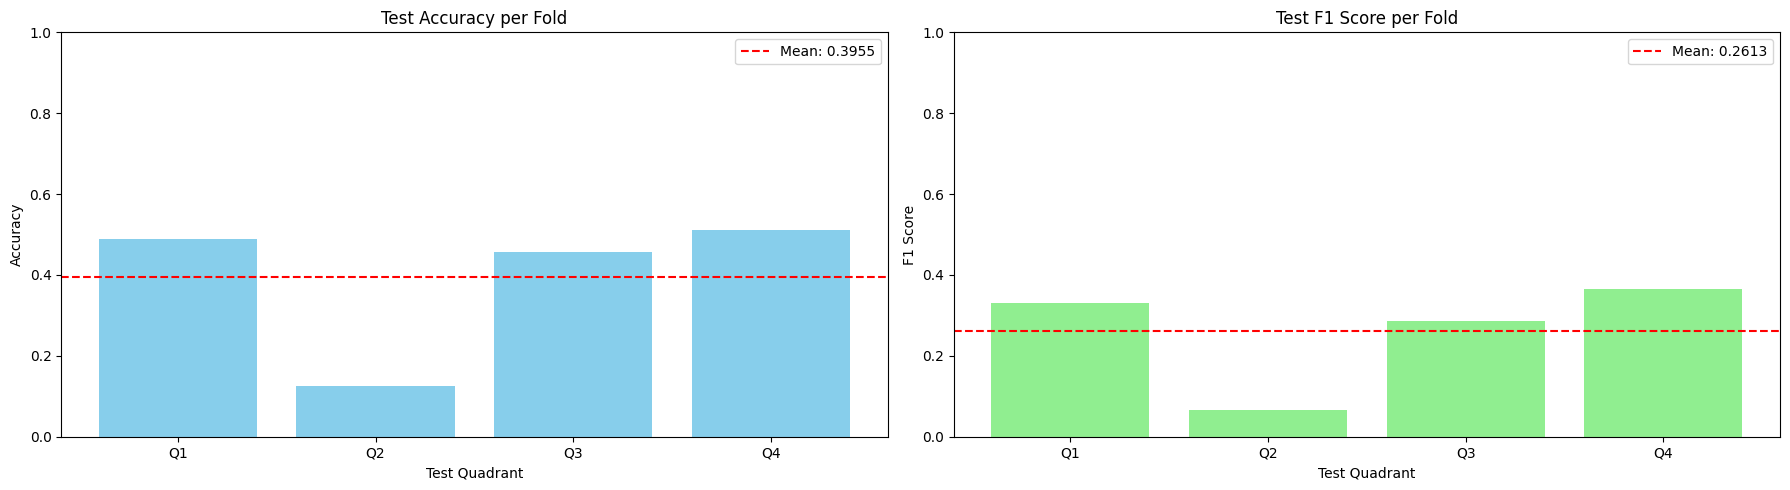

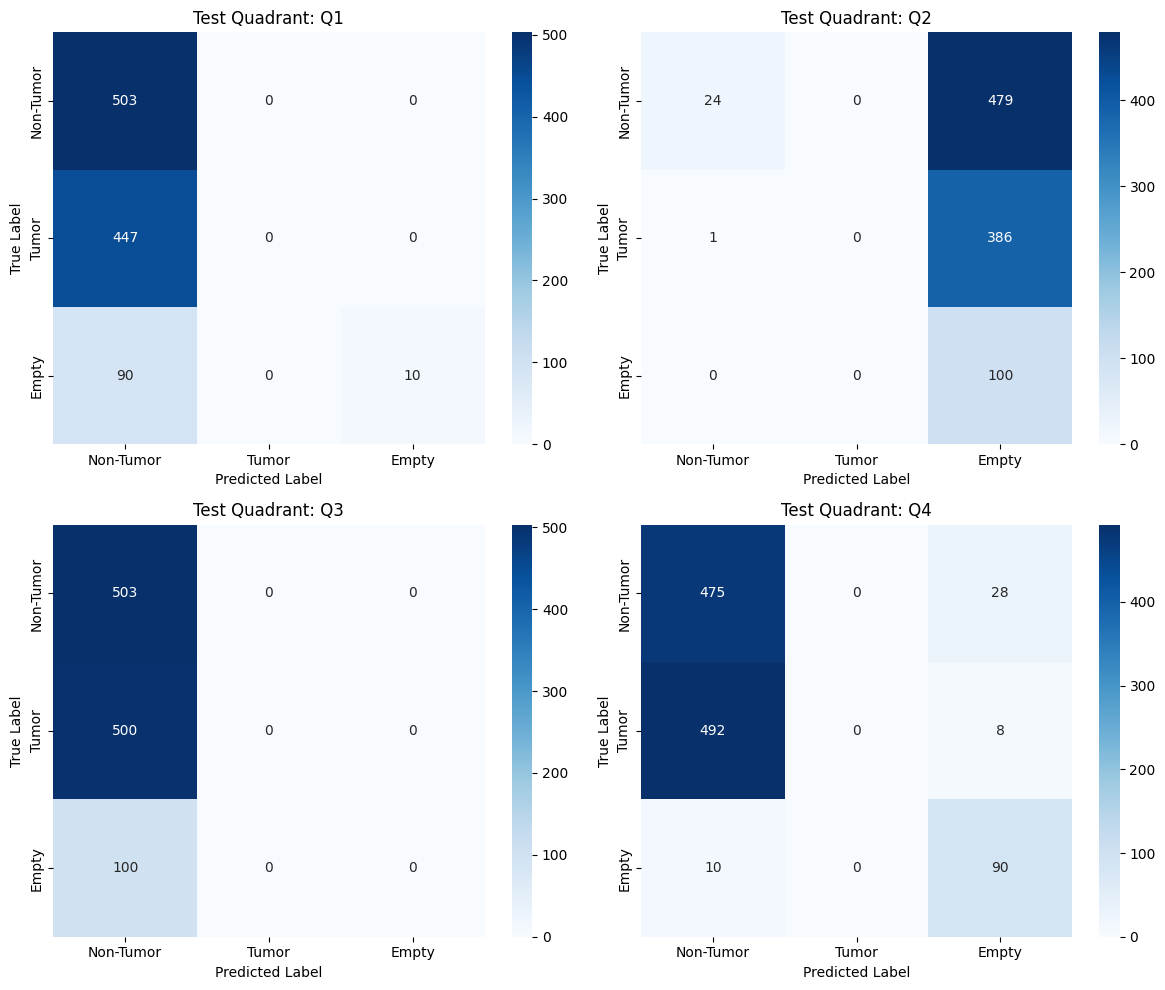

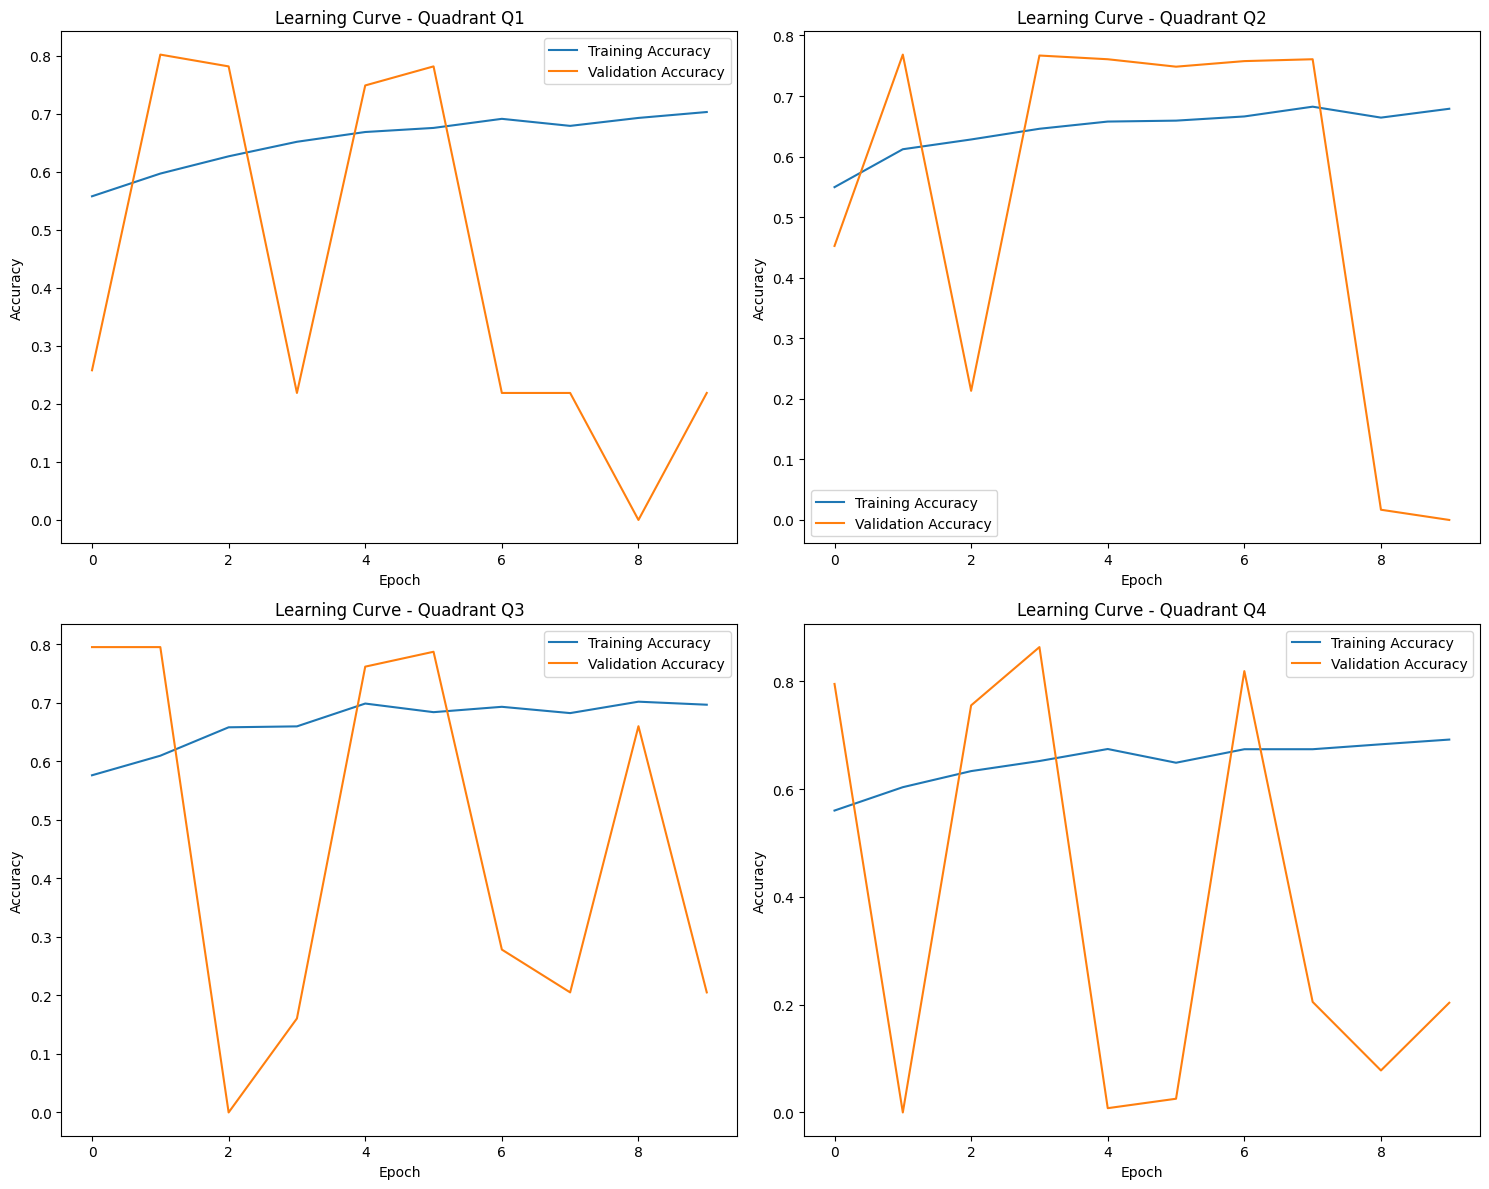

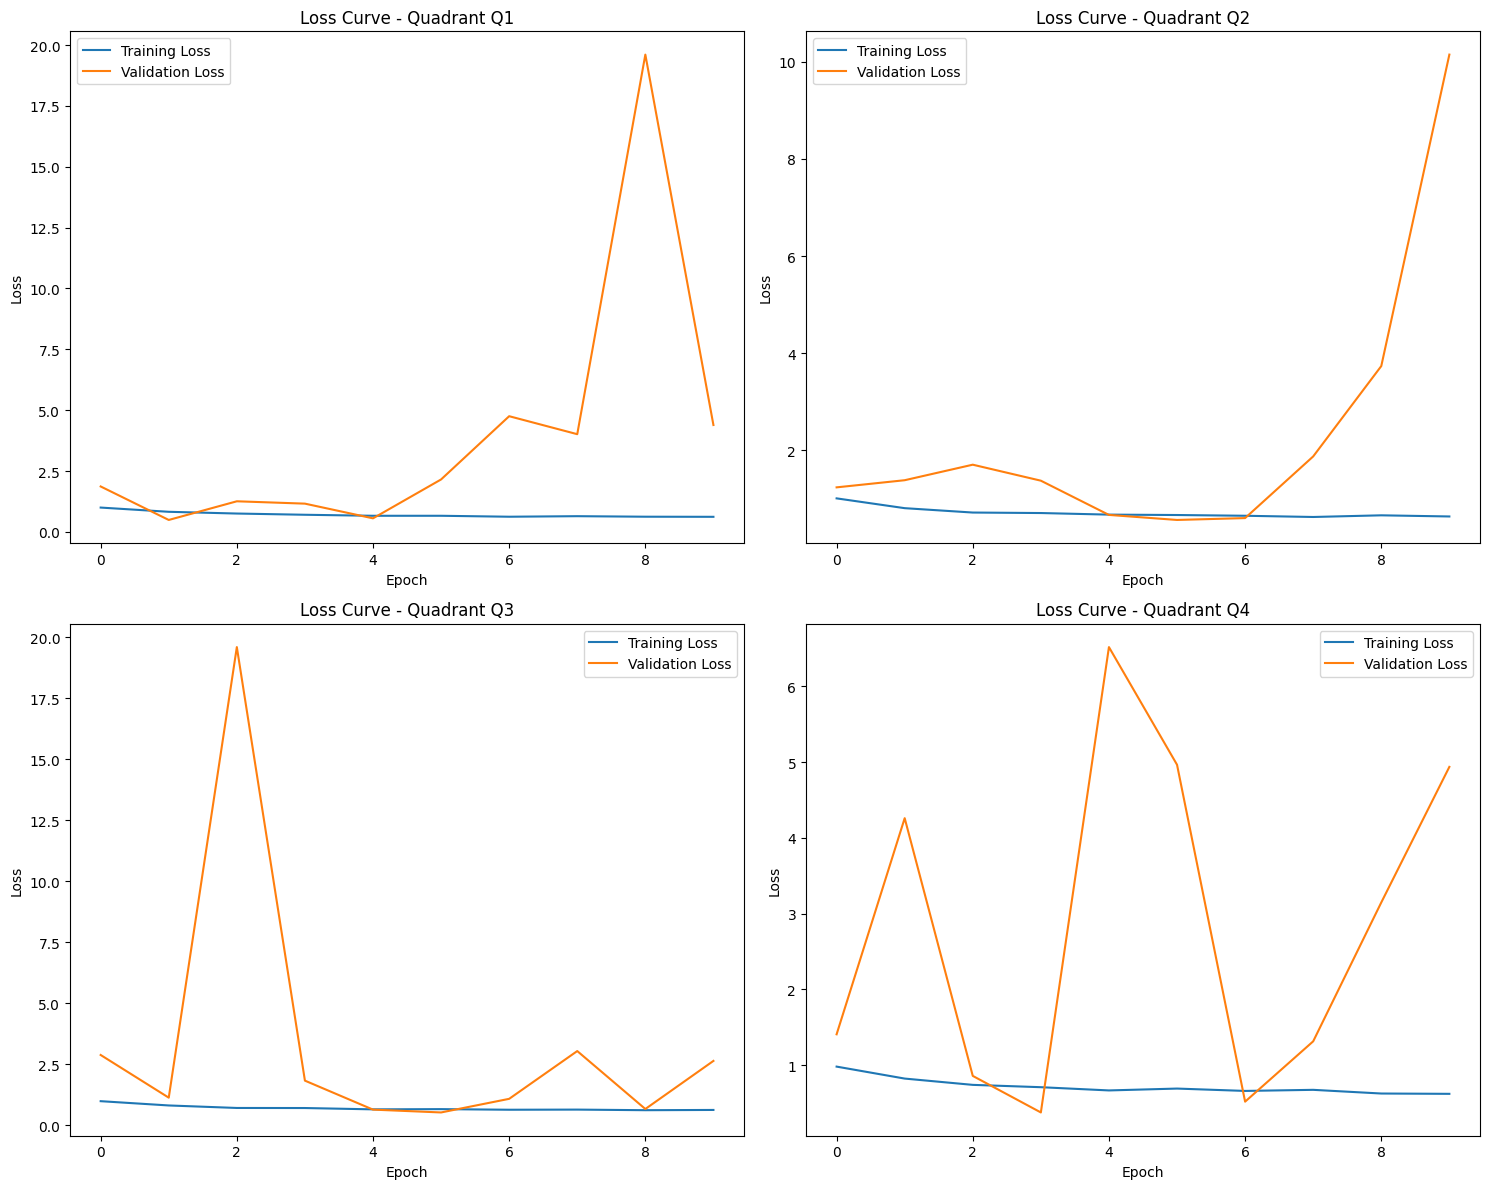

In [67]:
# Visualize cross validation results
plot_cv_metrics(cv_results)
plot_confusion_matrices(cv_results)
plot_learning_curves(cv_results)

In [52]:
# Save comprehensive cross validation report
def generate_classification_reports(results):
    """Generate classification reports for each test quadrant"""
    for i, quadrant in enumerate(results['test_quadrants']):
        print(f"\n=== Classification Report for Test Quadrant: {quadrant} ===")
        print(classification_report(results['y_true'][i], results['y_pred'][i], 
                                   target_names=['Non-Tumor', 'Tumor', 'Empty'],
                                   zero_division=0))
        
# Generate classification reports
generate_classification_reports(cv_results)


=== Classification Report for Test Quadrant: Q1 ===
              precision    recall  f1-score   support

   Non-Tumor       0.44      0.13      0.20       503
       Tumor       0.50      0.99      0.67       447
       Empty       0.45      0.10      0.16       100

    accuracy                           0.49      1050
   macro avg       0.47      0.41      0.35      1050
weighted avg       0.47      0.49      0.40      1050


=== Classification Report for Test Quadrant: Q2 ===
              precision    recall  f1-score   support

   Non-Tumor       0.96      0.05      0.09       503
       Tumor       0.00      0.00      0.00       387
       Empty       0.10      1.00      0.19       100

    accuracy                           0.13       990
   macro avg       0.35      0.35      0.09       990
weighted avg       0.50      0.13      0.07       990


=== Classification Report for Test Quadrant: Q3 ===
              precision    recall  f1-score   support

   Non-Tumor       0.46 

In [71]:
def create_inception_model(learning_rate=0.0001, input_shape=(224, 224, 3), seed=3888):
    K.clear_session()
    set_seed(seed)

    # Import Inception V3 model
    from tensorflow.keras.applications import InceptionV3

    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze at first, can be fine-tuned later

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [74]:
# Set training parameters
inception_params = {
    'epochs': 15,         # Number of training epochs
    'batch_size': 8,      # Batch size
    'learning_rate': 0.001, # Learning rate
}

# Run Inception V3 cross validation
inception_cv_results = quandrant_cv(
    X_datas=X_datas,
    y_datas=y_datas,
    model_func=create_inception_model,
    **inception_params
)


=== Fold 1 Cross Validation - Test Quadrant: Q1 ===
Training set shape: (3196, 224, 224, 3), Test set shape: (1050, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1509, 1387,  300], dtype=int64))
Test set label distribution: (array([0, 1, 2]), array([503, 447, 100], dtype=int64))
Epoch 1/15
320/320 [==============================] - 11s 28ms/step - loss: 0.6227 - accuracy: 0.7621 - val_loss: 0.7686 - val_accuracy: 0.7156
Epoch 2/15
320/320 [==============================] - 10s 30ms/step - loss: 0.4529 - accuracy: 0.7985 - val_loss: 1.3060 - val_accuracy: 0.4969
Epoch 3/15
320/320 [==============================] - 10s 32ms/step - loss: 0.3947 - accuracy: 0.8290 - val_loss: 0.8302 - val_accuracy: 0.7172
Epoch 4/15
320/320 [==============================] - 10s 32ms/step - loss: 0.3764 - accuracy: 0.8376 - val_loss: 1.0212 - val_accuracy: 0.6125
Epoch 5/15
320/320 [==============================] - 10s 32ms/step - loss: 0.3605 - accuracy: 0.8529 - val_loss: 1.5

Inception V3 model evaluation results:


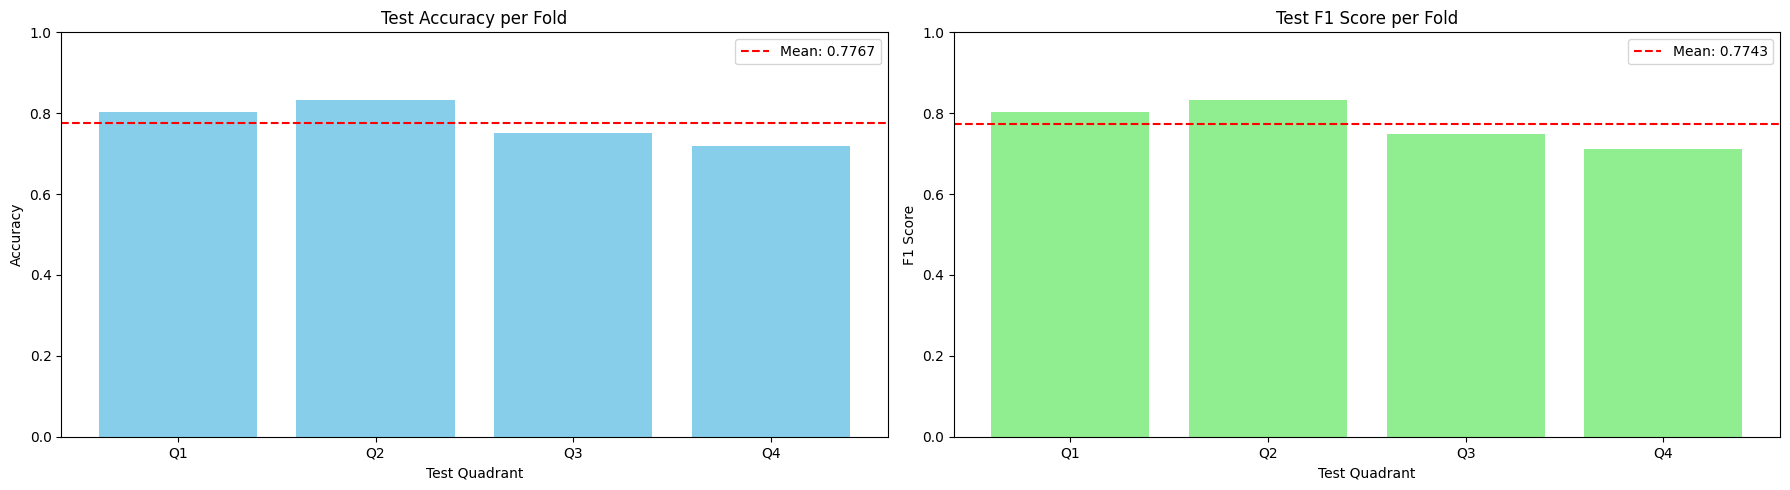

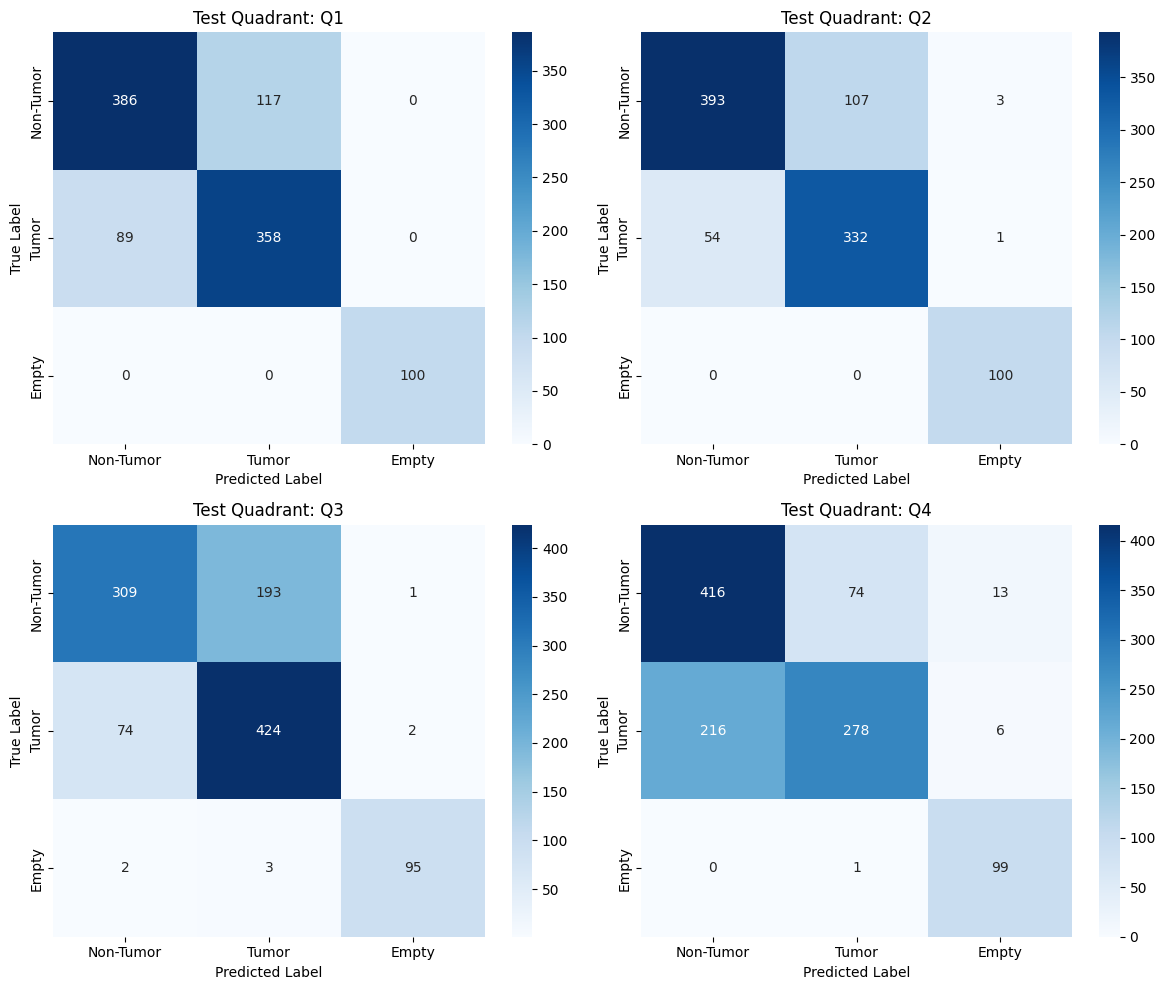

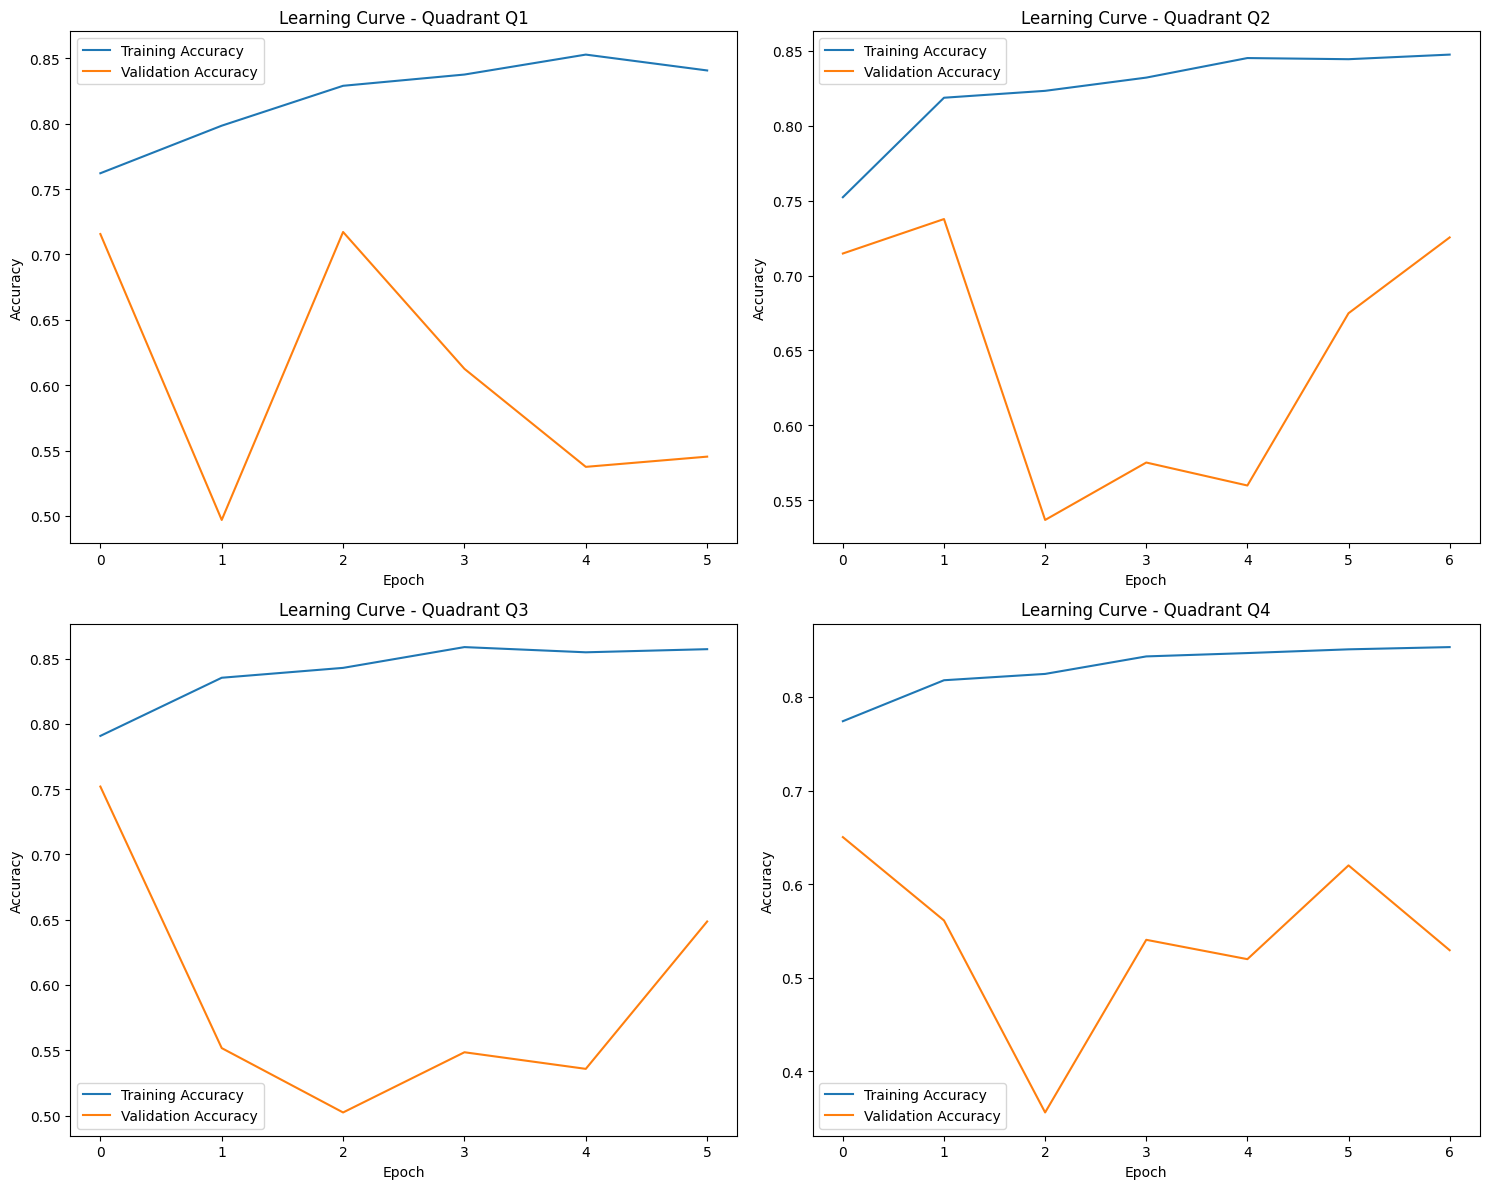

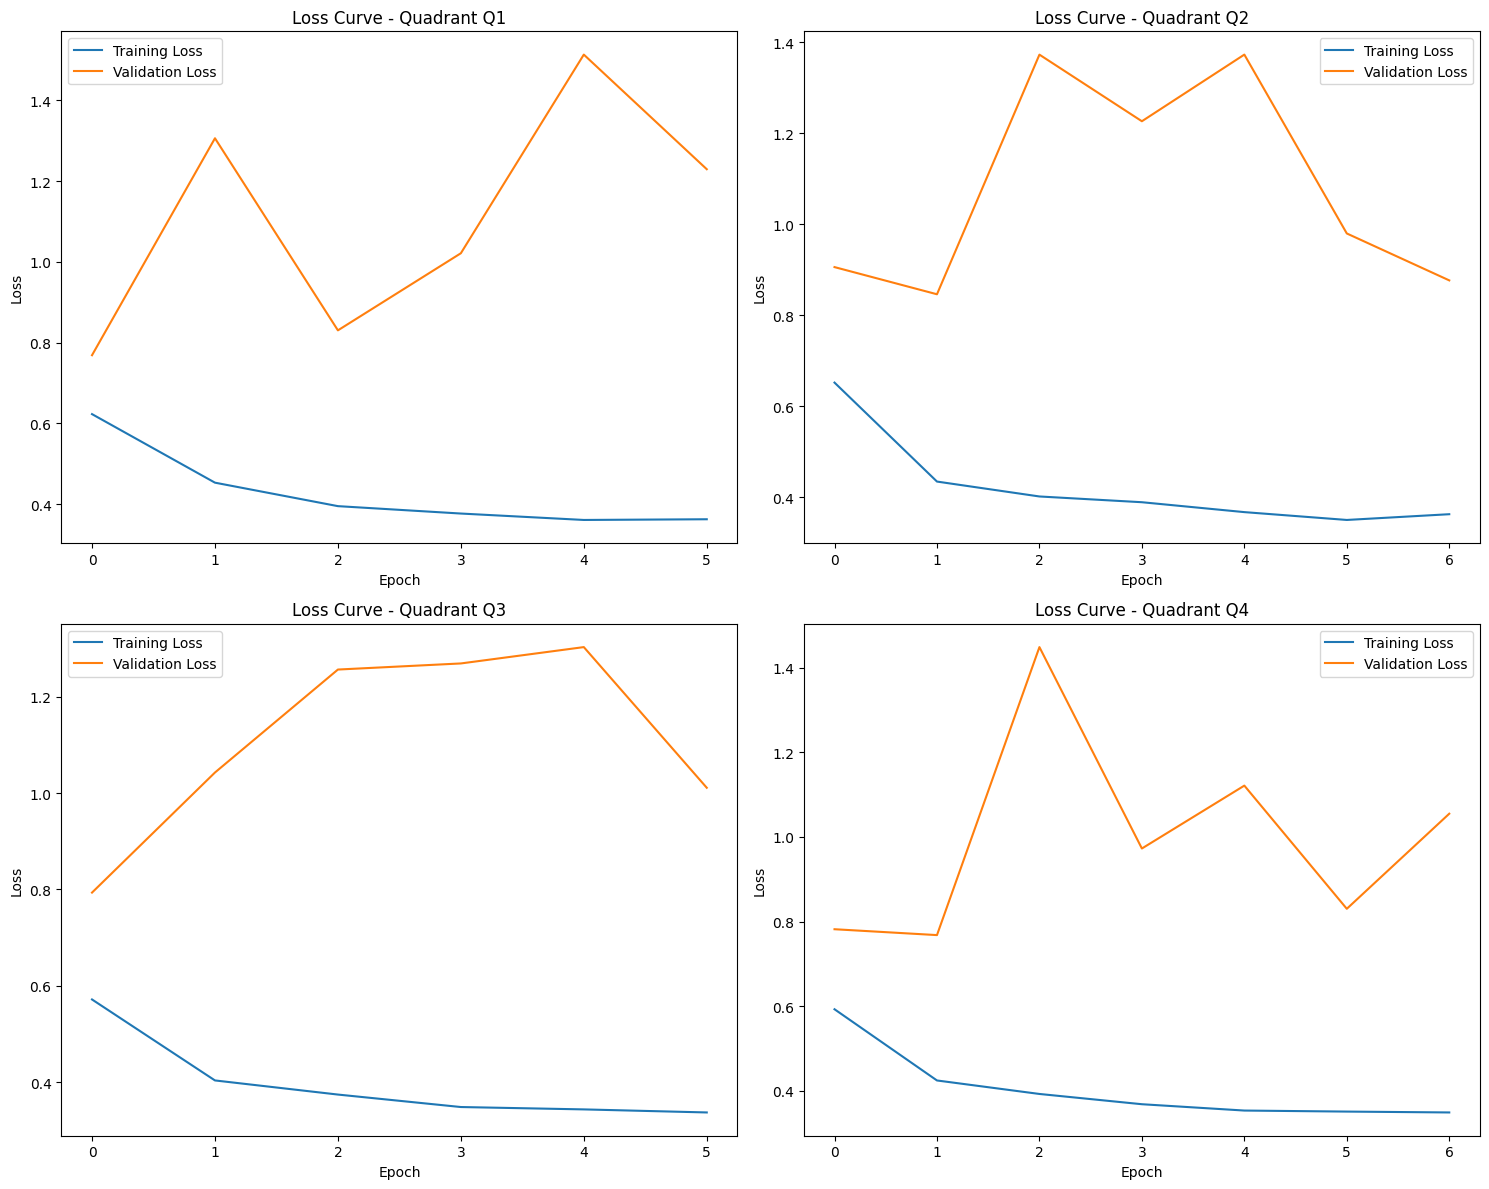

In [75]:
# Visualize Inception V3 cross validation results
print("Inception V3 model evaluation results:")
plot_cv_metrics(inception_cv_results)
plot_confusion_matrices(inception_cv_results)
plot_learning_curves(inception_cv_results)

In [76]:
generate_classification_reports(inception_cv_results)


=== Classification Report for Test Quadrant: Q1 ===
              precision    recall  f1-score   support

   Non-Tumor       0.81      0.77      0.79       503
       Tumor       0.75      0.80      0.78       447
       Empty       1.00      1.00      1.00       100

    accuracy                           0.80      1050
   macro avg       0.86      0.86      0.86      1050
weighted avg       0.81      0.80      0.80      1050


=== Classification Report for Test Quadrant: Q2 ===
              precision    recall  f1-score   support

   Non-Tumor       0.88      0.78      0.83       503
       Tumor       0.76      0.86      0.80       387
       Empty       0.96      1.00      0.98       100

    accuracy                           0.83       990
   macro avg       0.87      0.88      0.87       990
weighted avg       0.84      0.83      0.83       990


=== Classification Report for Test Quadrant: Q3 ===
              precision    recall  f1-score   support

   Non-Tumor       0.80 